# Extract Raster Values with Vector Data

Extracting raster values of pixels overlapping with vector data is one of the most common tasks for developers of earth observation applications.
This notebook shows on the basis of a small toy dataset how to perform this task in Python with the **eobox** package. 

In general there are tow two main approaches to solve this task in Python.
(I am eager to know if you see another approach or additional advantages or disadvantages that should be added to this list.)

1) The *rasterstats*-way: 
   * For each feature (point, line, polygon) in the vector dataset
      * get the geometry of the feature,
      * get the bounding box for that geometry,
      * get the raster data corresponding to the bounding box as array (extraction core),
      * rasterize the geometry such that it correponds to the array,
      * return only the raster values overlapping with the rasterized geometry.
    
A way of doing this in Python can be found in the 
    ``gen_zonal_stats`` [function](https://pythonhosted.org/rasterstats/rasterstats.html#rasterstats.gen_zonal_stats) 
    implemented in the **rasterstats** [package](https://pythonhosted.org/rasterstats/index.html).
  
2) The *rasterize*-way:
   * Rasterize the whole vector dataset such that the rasterized raster 
     matches the raster data from which to extract the values 
     (e.g. with the ``gdal_rasterize`` [function](https://www.gdal.org/gdal_rasterize.html)).
   * load the rasterized data as array and create a mask, 
   * load the raster from which to extract the data as array and select the values to be kept by the mask.
   
This tutorial shows how to use the ``extract`` [function](https://eo-box.readthedocs.io/en/latest/_modules/eobox/extraction/extraction.html#extract) implemented in the **eobox** [package](https://eo-box.readthedocs.io/en/latest/index.html) to go this way.
   
There is a major difference between the two approaches which might help you to find the best for your case:
The first approach is memory sparing since the whole raster does not need to be loaded in memory at once, which is necessary in the second approach. 
However, if your vector dataset contains many features, it might be much faster to go for the second approach since it is not necessary to loop through all the features in Python. 

Let's get stated and import the required modules. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fnmatch
import geopandas as gpd
import os
import pandas as pd
from pathlib import Path

from eobox.raster import extraction
from eobox.raster.extraction import convert_df_to_geodf
from eobox import sampledata


We now load a small sample dataset from which we can derive all requird arguments for running the ``extract`` function.

Note that the sample dataset is S2 L1C that comes in different resolutions. 
Extraction from multiple resolutions is not supported and handling it is (so far) the responsibilit of the user.

Here we only slect the 10m bands for extraction.

In [2]:
dataset = sampledata.get_dataset("s2l1c")

src_vector = dataset["vector_file"]
burn_attribute = "pid"  # should be unique for the polygons and not contain zero
src_raster = fnmatch.filter(dataset["raster_files"], "*B0[2,3,4,8]*")  # 10 m bands
dst_names = ["_".join(Path(src).stem.split("_")[1::]) for src in src_raster]
extraction_dir = Path("s2l1c_ref__s2l1c/s2_l1c/10m")

print("***ARGUMENTS***")
print("\nsrc_vector:\n-----------\n -", src_vector)
print("\ndst_dir:\n--------\n -", extraction_dir)
print("\nsrc_raster:\n-----------\n -", "\n - ".join(src_raster))
print("\ndst_names:\n----------\n -", "\n - ".join(dst_names))
print("\n***ARGUMENTS - END***")

***ARGUMENTS***

src_vector:
-----------
 - /home/ben/Devel/Packages/eo-box/eobox/sampledata/data/s2l1c/s2l1c_ref.gpkg

dst_dir:
--------
 - s2l1c_ref__s2l1c/s2_l1c/10m

src_raster:
-----------
 - /home/ben/Devel/Packages/eo-box/eobox/sampledata/data/s2l1c/IMG_DATA/T33UUU_20170216T102101_B08.jp2
 - /home/ben/Devel/Packages/eo-box/eobox/sampledata/data/s2l1c/IMG_DATA/T33UUU_20170216T102101_B02.jp2
 - /home/ben/Devel/Packages/eo-box/eobox/sampledata/data/s2l1c/IMG_DATA/T33UUU_20170216T102101_B03.jp2
 - /home/ben/Devel/Packages/eo-box/eobox/sampledata/data/s2l1c/IMG_DATA/T33UUU_20170216T102101_B04.jp2

dst_names:
----------
 - 20170216T102101_B08
 - 20170216T102101_B02
 - 20170216T102101_B03
 - 20170216T102101_B04

***ARGUMENTS - END***


The vector dataset looks as follows:

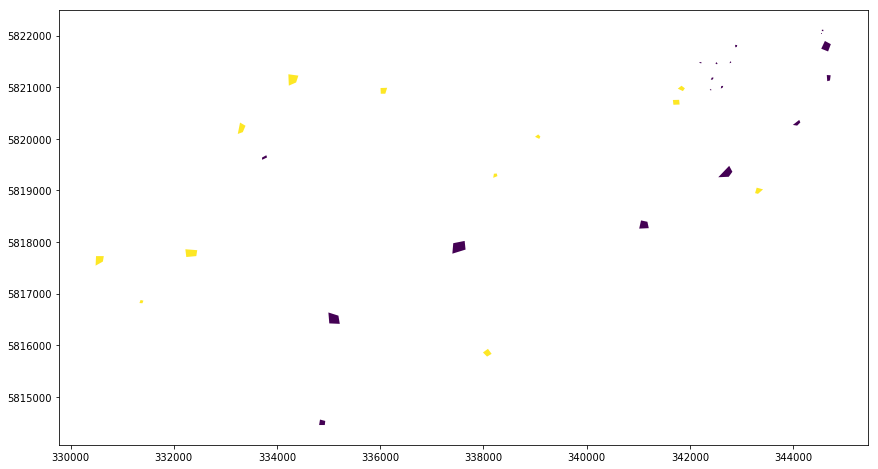

In [3]:
gdf = gpd.read_file(src_vector)
gdf.plot(column="cid", figsize=(18, 8))

Note that the *cid* column represents the classes water (*cid*:1) and forest (*cid*:2).
Even though we are usually interested in such an attribute we use as burn attribute the *pid* column contains unique ids for the polygons.
Using a unique id for each feature is recommended since it assures that for each extracted pixel the polygon it belongs to can easily been identified.
We will see later that it is easy to merge the *cid* information or any other information of the vector data attribute table can easily be merged into the extrected data.

But now let's do the extraction.

In [4]:
%%time
extraction.extract(src_vector=src_vector,
                   burn_attribute=burn_attribute,
                   src_raster=src_raster,
                   dst_names=dst_names,
                   dst_dir=extraction_dir)

100%|██████████| 4/4 [00:00<00:00, 11.67it/s]

CPU times: user 2.18 s, sys: 343 ms, total: 2.53 s
Wall time: 397 ms


0

So what just happened? - Roughly the function made what was described above under the *rasterize*-way and stored the extracted data and some auxiliary information to .npy files:

In [5]:
list(extraction_dir.glob("*.npy"))

[PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/aux_coord_x.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/20170216T102101_B04.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/20170216T102101_B02.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/aux_coord_y.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/20170216T102101_B08.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/aux_vector_pid.npy'),
 PosixPath('s2l1c_ref__s2l1c/s2_l1c/10m/20170216T102101_B03.npy')]

Note that the aux(iliary) variables are
* *aux_coord_x*: the x coordinates of the pixels,
* *aux_coord_y*: the y coordinates of the pixels,
* *aux_coord_y*: the polygon id (here) or whatever attribute has been passed ``burn_attribute`` before.

The rest of the variables contain the data extracted from the raster layers.

* 20170216T102101_B02.npy
* 20170216T102101_B03.npy
* 20170216T102101_B04.npy
* 20170216T102101_B08.npy

It is worth noting that the function checks what has already been extracted by using the ``dst_names``. 
Thus, only the ``dst_names`` that alread exist are skipped.
So far, it is the responsibility of the user to delete existing bands in case they should be re-extracted.

With the the function ``load_extracted`` it is easy to load the data.
It has a couple of options which returns different dataframes:

* The defaults return all variable in columns.

* ``patterns`` can be used to load specific variables matching a list of patterns.

In [6]:
extraction.load_extracted(extraction_dir, patterns=["aux_*.npy"]).head()

,aux_coord_x,aux_coord_y,aux_vector_pid
0,344545.0,5822035.0,17
1,344555.0,5822035.0,17
2,344615.0,5821885.0,6
3,344625.0,5821885.0,6
4,344615.0,5821875.0,6


In [7]:
extraction.load_extracted(extraction_dir, patterns=["aux_vector_pid.npy", "*_B??.npy"]).head()

,aux_vector_pid,20170216T102101_B04,20170216T102101_B02,20170216T102101_B08,20170216T102101_B03
0,17,928,1456,672,1072
1,17,928,1392,672,1040
2,6,928,1456,608,1072
3,6,864,1424,608,1072
4,6,928,1424,608,1072


* ``vars_in_cols`` can be used to load the variables in the columns.
  
  This does not make so much sense here, but if you have e.g. a long time series of the NDVI and you want to make time series analysis you might want to have the dates in the rows. 

In [8]:
extraction.load_extracted(extraction_dir, patterns=["*B??.npy"], vars_in_cols=False).head()

,0,1,2,3,4,5,6,7,8,9,...,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499
20170216T102101_B04,928,928,928,864,928,864,864,864,864,928,...,880,912,880,848,848,848,816,816,816,816
20170216T102101_B02,1456,1392,1456,1424,1424,1424,1424,1392,1424,1392,...,1448,1464,1448,1432,1448,1480,1432,1448,1400,1400
20170216T102101_B08,672,672,608,608,608,608,608,608,608,608,...,624,656,592,560,592,592,592,560,560,560
20170216T102101_B03,1072,1040,1072,1072,1072,1072,1040,1040,1040,1072,...,1056,1120,1056,1056,1056,1056,1056,1056,1056,1056


You can also get the *head* of the data loaded by ``load_extracted``, i.e. the first five rows.

In [9]:
extraction.load_extracted(extraction_dir, vars_in_cols=False, head=True)

,0,1,2,3,4,5
aux_coord_x,344545.0,344555.0,344615.0,344625.0,344615.0,344625.0
20170216T102101_B04,928.0,928.0,928.0,864.0,928.0,864.0
20170216T102101_B02,1456.0,1392.0,1456.0,1424.0,1424.0,1424.0
aux_coord_y,5822035.0,5822035.0,5821885.0,5821885.0,5821875.0,5821875.0
20170216T102101_B08,672.0,672.0,608.0,608.0,608.0,608.0
aux_vector_pid,17.0,17.0,6.0,6.0,6.0,6.0
20170216T102101_B03,1072.0,1040.0,1072.0,1072.0,1072.0,1072.0


And finally you can convert the data to a geodataframe.

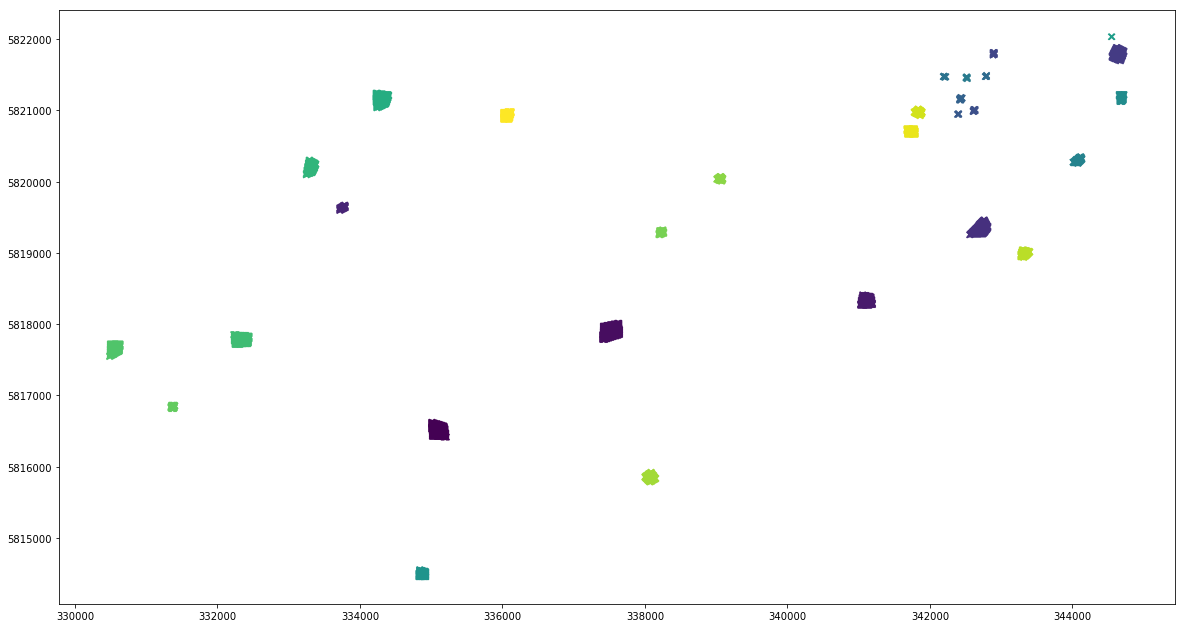

In [11]:
df_extracted = extraction.load_extracted(extraction_dir, patterns=["aux_*.npy", "*_B??.npy"])
gdf_extracted = convert_df_to_geodf(df_extracted, crs=extraction_dir)
gdf_extracted.plot(column='aux_vector_pid', marker='x', figsize=(20, 12))

It has been said above that it is easy to join the extracted values to the values stored in the attribute table of the vector file.

In [12]:
df_extracted = df_extracted.merge(gdf[["pid", "cid", "comment"]], how="left", left_on="aux_vector_pid", right_on="pid")
df_extracted.head()

,aux_coord_x,aux_coord_y,aux_vector_pid,20170216T102101_B04,20170216T102101_B02,20170216T102101_B08,20170216T102101_B03,geometry,pid,cid,comment
0,344545.0,5822035.0,17,928,1456,672,1072,POINT (344545 5822035),17,1,partially out; expecting: 2 - with default ras...
1,344555.0,5822035.0,17,928,1392,672,1040,POINT (344555 5822035),17,1,partially out; expecting: 2 - with default ras...
2,344615.0,5821885.0,6,928,1456,608,1072,POINT (344615 5821885),6,1,None
3,344625.0,5821885.0,6,864,1424,608,1072,POINT (344625 5821885),6,1,None
4,344615.0,5821875.0,6,928,1424,608,1072,POINT (344615 5821875),6,1,None


And now you can start analyzing the data.

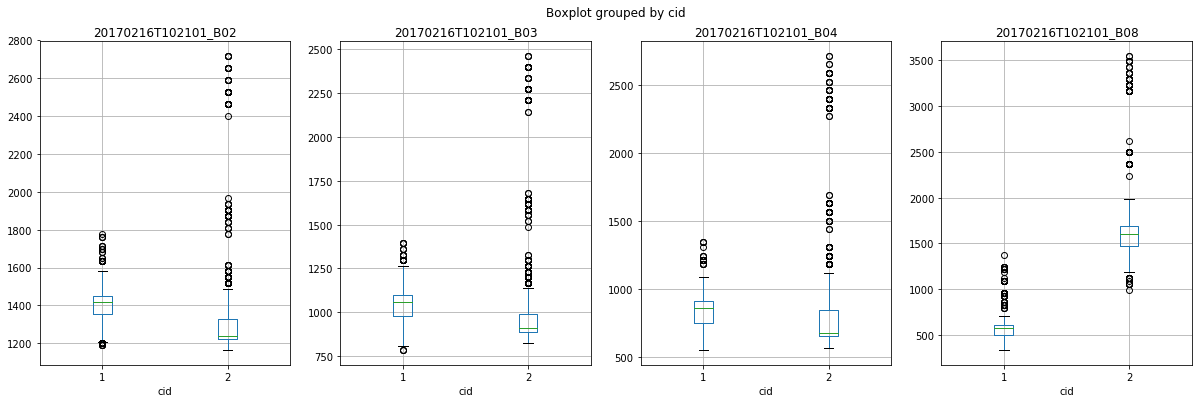

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for ax, var in zip(axes.flatten(), ["20170216T102101_B02", "20170216T102101_B03", "20170216T102101_B04", "20170216T102101_B08"]):
    df_extracted.boxplot(column=var, by="cid", ax=ax)